In [1]:
#import all necessary packages

import pyspark
from pyspark.sql import SparkSession, types as typ, functions as f

from pyspark.ml import Pipeline
import pyspark.ml.feature as ft
import pyspark.ml.classification as cl
import sklearn.metrics as sk_me

import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Part I

In [3]:
#read the data
d1 = spark.read.csv('rel.csv', header=False)
#rename columns
d1 = (d1.withColumnRenamed('_c0', 'Col1')
        .withColumnRenamed('_c1', 'Col2')) 

#show the first 5
d1.show(5)

+--------+--------+
|    Col1|    Col2|
+--------+--------+
|C0005790|C0005778|
|C1255279|C3537249|
|C1255446|C0002520|
|C1255552|C0596019|
|C1254417|C0004611|
+--------+--------+
only showing top 5 rows



In [4]:
# Step 1: Order the pair of strings alphabetically.

df1 = d1.withColumn('C1', f.when(d1.Col1 <= d1.Col2, d1.Col1).otherwise(d1.Col2))
df2 = df1.withColumn('C2', f.when(d1.Col1 > d1.Col2, d1.Col1).otherwise(d1.Col2))

#remain the 2 new columns
df3 = df2.drop('Col1', 'Col2')
df3.show(5)

+--------+--------+
|      C1|      C2|
+--------+--------+
|C0005778|C0005790|
|C1255279|C3537249|
|C0002520|C1255446|
|C0596019|C1255552|
|C0004611|C1254417|
+--------+--------+
only showing top 5 rows



In [5]:
# Step 2: 
#(1) Count the number of instances for each ordered pair resulted in Step 1.

out = df3.groupby(['C1', 'C2']).count()
out = out.orderBy(['C1','C2'],ascending=True)
out.show(5)

+--------+--------+-----+
|      C1|      C2|count|
+--------+--------+-----+
|C0000005|C0036775|    4|
|C0000039|C0000039|   22|
|C0000039|C0001555|    2|
|C0000039|C0001688|    2|
|C0000039|C0002776|    2|
+--------+--------+-----+
only showing top 5 rows



In [6]:
#(2) Output the result in a plain text file (named as “pair-count.txt”). 

#prepare for the correct format to the output
temp1 = out.withColumn('combined',f.concat_ws(" ", out.C1,out.C2))
temp2 = (temp1.withColumn('splitted', f.split('combined', ' '))
         .withColumn('joined', f.array_join(f.col('splitted'), '", "'))
         .withColumn('warpped', f.concat(f.lit('"'), f.col('joined'), f.lit('"'))))
temp2 = temp2.withColumn('pair-count',f.concat_ws(" ", f.col('warpped'),f.col('count')))
fin = temp2.drop('C1', 'C2', 'count', 'combined', 'splitted', 'joined', 'warpped')
fin.show(5)

#output the final result
fin.coalesce(1).write.format("text").option("header", "false").mode("append").save("pair-count.txt")

+--------------------+
|          pair-count|
+--------------------+
|"C0000005", "C003...|
|"C0000039", "C000...|
|"C0000039", "C000...|
|"C0000039", "C000...|
|"C0000039", "C000...|
+--------------------+
only showing top 5 rows



In [7]:
# Step 3: Count the total number of ordered pairs.

out.count()

12946540

## Part II

In [3]:
#read data without schema
d2NoSchema = spark.read.csv('diabetes.csv', header=True)

d2NoSchema.show(5)
print(d2NoSchema.dtypes)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows

[('Pregnancies', 'string'), ('Glucose', 'string'), ('BloodPressure', 'strin

In [4]:
# read data with schema

labels = [
    ('Pregnancies', typ.IntegerType()),
    ('Glucose', typ.IntegerType()),
    ('BloodPressure', typ.IntegerType()),
    ('SkinThickness', typ.IntegerType()),
    ('Insulin', typ.IntegerType()),
    ('BMI', typ.DoubleType()),
    ('DiabetesPedigreeFunction', typ.DoubleType()),
    ('Age', typ.IntegerType()),
    ('Outcome', typ.IntegerType())
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])

d2 = spark.read.csv('diabetes.csv', header=True, schema=schema)

In [5]:
# Step 1: Remove the rows where the column “BloodPressure”, “BMI” or “Glucose” is zero 
#(note: remove the row as long as one of the three columns is zero).

df1 = d2.filter((d2.BloodPressure != 0) & (d2.BMI != 0) & (d2.Glucose != 0))

#check the result
df1.filter((df1.BloodPressure == 0) | (df1.BMI == 0) | (df1.Glucose == 0)).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [6]:
# Step 2: Convert the categorical column “Pregnancies” into one-hot encoding.
encoder = ft.OneHotEncoder(inputCol='Pregnancies', outputCol='Pregnancies_VEC')
oheModel = encoder.fit(df1)
df2 = oheModel.transform(df1)

df2.select('Pregnancies_VEC').take(5)

[Row(Pregnancies_VEC=SparseVector(17, {6: 1.0})),
 Row(Pregnancies_VEC=SparseVector(17, {1: 1.0})),
 Row(Pregnancies_VEC=SparseVector(17, {8: 1.0})),
 Row(Pregnancies_VEC=SparseVector(17, {1: 1.0})),
 Row(Pregnancies_VEC=SparseVector(17, {0: 1.0}))]

In [7]:
# Step 3: Create a single column with all the features collated together using VectorAssembler.

featuresCreator = ft.VectorAssembler(inputCols=[ col[0] for col in labels[1:-1]] + [encoder.getOutputCol()], 
                                     outputCol='features')

res = featuresCreator.transform(df2).take(2)
res

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1, Pregnancies_VEC=SparseVector(17, {6: 1.0}), features=SparseVector(24, {0: 148.0, 1: 72.0, 2: 35.0, 4: 33.6, 5: 0.627, 6: 50.0, 13: 1.0})),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.6, DiabetesPedigreeFunction=0.351, Age=31, Outcome=0, Pregnancies_VEC=SparseVector(17, {1: 1.0}), features=SparseVector(24, {0: 85.0, 1: 66.0, 2: 29.0, 4: 26.6, 5: 0.351, 6: 31.0, 8: 1.0}))]

In [8]:
# Step 4: Random split the collated data into training (70%) and testing (30%) datasets and use 2017 as the seed.

d2_train, d2_test = df1.randomSplit([0.7, 0.3], seed=2017)

In [9]:
# Step 5: Implement a random forest classifier and specify the number of decision trees as 20.

classifier = cl.RandomForestClassifier(
    numTrees=20, 
    maxDepth=5, 
    labelCol='Outcome')

pipeline = Pipeline(
    stages=[
        encoder,
        featuresCreator, 
        classifier])

model = pipeline.fit(d2_train)
test = model.transform(d2_test)

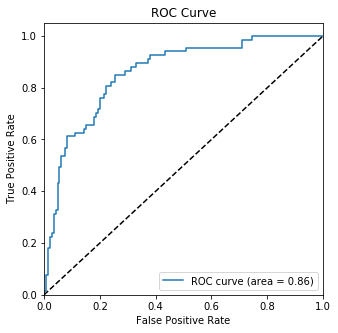

In [10]:
# Step 6: Evaluate the performance of the random forest classifier using the ROC curve metric.

probArr = test.select('probability','Outcome') \
                    .rdd \
                    .map( lambda row: [row[0][1], row[1]] ).collect()
probArr = np.array(probArr)

fpr, tpr, thresholds = sk_me.roc_curve( probArr[:,1], probArr[:,0], pos_label=1)
roc_auc = sk_me.auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()